# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import models,layers
from keras.preprocessing import image
from keras.utils import to_categorical
import tensorflow as tf
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


# Loading Dataset

In [3]:
#folder paths
goal_train='/content/drive/MyDrive/Datasets/Goal Line Detection/ball/train/goal_train'
goal_test='/content/drive/MyDrive/Datasets/Goal Line Detection/ball/test/goal_test'

nogoal_train = '/content/drive/MyDrive/Datasets/Goal Line Detection/ball/train/nogoal_train'
nogoal_test = '/content/drive/MyDrive/Datasets/Goal Line Detection/ball/test/nogoal_test'


In [4]:
#function to load images as 2D arrays
def load_img(folder):
    imgs=[]
    for i in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,i))
        #images read in grayscale, i.e. only 2 channels
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img=cv2.resize(img,(256,256))
        imgs.append(img)
    return imgs

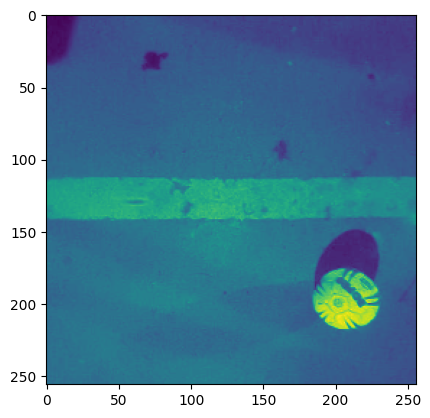

In [5]:
#Looking at a sample image
k = load_img(goal_train)
plt.imshow(k[0])

In [6]:
k[0].shape

(256, 256)

# Train Test Split

In [7]:
#Function to get numpy array representation of images in a folder
def getarray(folder):
  arrays=np.array(load_img(folder))
  arrays=np.reshape(arrays,(arrays.shape[0],arrays.shape[1]*arrays.shape[2]))
  return arrays

In [8]:
# Getting array from images
x1_train = getarray(goal_train)
x2_train = getarray(nogoal_train)

x1_test=getarray(goal_test)
x2_test=getarray(nogoal_test)

In [9]:
# Getting x values - Images as arrays
x_train = np.concatenate((x1_train,x2_train),axis=0)
x_test = np.concatenate((x1_test,x2_test),axis=0)

In [10]:
print(x_train.shape, x_test.shape)

(32, 65536) (8, 65536)


In [11]:
# Getting y values - binary classes of 'goal' or 'not goal'
y0_train=np.zeros(len(x1_train),dtype=bool)
y1_train=np.ones(len(x2_train),dtype=bool)

y_train= np.concatenate((y1_train,y0_train),axis=0)
y_train=y_train.reshape(len(y_train),1)

y0_test=np.zeros(len(x1_test),dtype=bool)
y1_test=np.ones(len(x2_test),dtype=bool)

y_test= np.concatenate((y1_test,y0_test),axis=0)
y_test=y_test.reshape(len(y_test),1)

In [12]:
print(y_train.shape, y_test.shape)

(32, 1) (8, 1)


Now, we have train test splits of x values (images of a football near a goal line) and y values (classes - goal or no goal)

# Linear Discriminant Analysis

LDA will allow us to find one single axis (since this is binary classification, 2 classes means 2-1=1 axis will be made) to separate the two classes. It finds an axis which maximizes separability between classes while minimizing scatter within a class.

This is done by projecting the features onto a single axis. Each feature (we have 65536 features = 256*256 pixels of image in this case) is given a coefficient to determine its importance.

In [13]:
# Fitting LDA model
lda = LDA()
lda.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

In [14]:
# Getting the coefficients assigned by LDA for each feature i.e. each pixel of the training images
coefficients = lda.coef_
map = coefficients.reshape(256, 256)

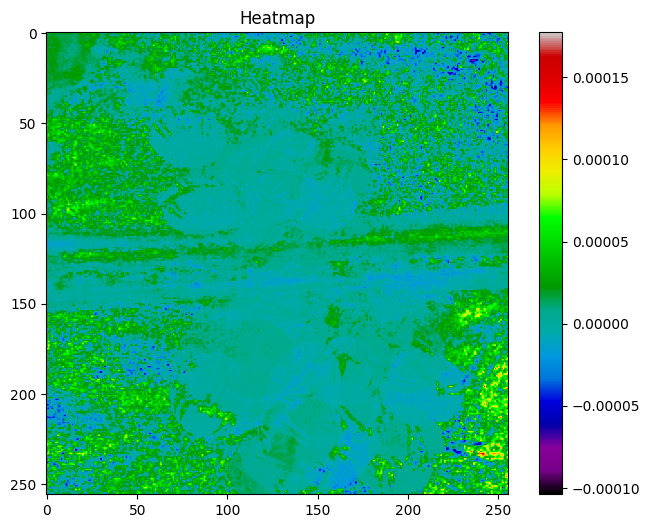

In [16]:
# Plotting it to see what features the LDA is deeming important while finding separability between classes
plt.figure(figsize=(8, 6))
plt.imshow(map, cmap='nipy_spectral')
plt.colorbar()
plt.title('Heatmap')
plt.show()

LDA seems to be able to identify the placement of the football and the goal line decently. It is assigning weights closer to 0 for the football and goal line, as the coefficient weights' linear composite will form the equation for a line which creates maximum separability between classes.

In [17]:
# Prediction on test dataset
y_pred=lda.predict(x_test)
y_pred

array([ True,  True, False,  True,  True, False, False, False])

In [18]:
accuracy_score(y_test,y_pred)

0.75

In [19]:
confusion_matrix(y_test,y_pred)

array([[3, 1],
       [1, 3]])

# ANN

In [20]:
y_train = y_train.reshape(32)

In [21]:
y_test = y_test.reshape(8)

In [22]:
network=models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape = (256*256, )))
network.add(layers.Dense(256, activation = 'relu'))

network.add(layers.Dense(128, activation = 'leaky_relu'))
network.add(layers.Dense(64, activation = 'leaky_relu',name='last_layer'))

network.add(layers.Dense(1, activation = 'sigmoid'))

network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               33554944  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 last_layer (Dense)          (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33727489 (128.66 MB)
Trainable params: 33727489 (128.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
network.compile(optimizer = 'Adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [24]:
x_train = x_train.astype('float32') / 255
x_test= x_test.astype('float32') / 255

In [25]:
network.fit(x_train,y_train,epochs=20)


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.6960 - accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 544ms/step - loss: 0.2534 - accuracy: 0.9375
Epoch 3/20
1/1 [==============================] - 1s 525ms/step - loss: 31.7524 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 531ms/step - loss: 8.0432 - accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 528ms/step - loss: 15.6883 - accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 1s 532ms/step - loss: 14.6295 - accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 1s 544ms/step - loss: 7.1770 - accuracy: 0.5000
Epoch 8/20
1/1 [==============================] - 1s 526ms/step - loss: 0.5186 - accuracy: 0.7500
Epoch 9/20
1/1 [==============================] - 1s 537ms/step - loss: 4.9768 - accuracy: 0.5000
Epoch 10/20
1/1 [==============================] - 1s 530ms/step - loss: 3.6765 - accuracy: 0.5000
Epoch 11/20
1/1 [==

In [26]:
network.evaluate(x_test,y_test)

1/1 [==============================] - 0s 204ms/step - loss: 1.3552 - accuracy: 0.5000


[1.3551905155181885, 0.5]

In [27]:
network.predict(x_test)

1/1 [==============================] - 0s 124ms/step


array([[0.06732035],
       [0.07631695],
       [0.06025138],
       [0.07167088],
       [0.02931604],
       [0.04045114],
       [0.0238394 ],
       [0.02984215]], dtype=float32)

In [28]:
# function to get activation map of the last layer in the model
def get_activations(model, layer_name, input_data):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    activations = intermediate_layer_model(input_data)
    return activations

In [29]:
layer_name = 'last_layer'

sample_image = np.expand_dims(x_train[0], axis=0)
activations = get_activations(network, layer_name, sample_image)

In [30]:
activations

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 1.2860451 , -5.282458  , -2.835653  , -2.3554382 , -9.313291  ,
        -4.306504  , 20.220716  , -2.8915746 , -1.0645007 , 14.66001   ,
        21.483223  ,  7.4292245 , -2.6889493 , -2.0457866 , -3.8001192 ,
        27.914158  , -8.0312605 , 39.7579    , -1.7712145 , 42.886314  ,
        21.275806  ,  4.05239   , -1.8019205 , -2.388573  , 10.306092  ,
        -2.3765135 , -0.16974424, -0.43924174, 49.961956  ,  2.957617  ,
        -1.6983738 ,  2.357268  , -1.7647864 , -4.0505786 , -4.3997746 ,
        -6.459165  ,  1.4831771 ,  3.0101285 , -2.995422  , -4.2435117 ,
        31.580524  , -2.2926226 , -1.3515522 , -4.554759  ,  1.5812924 ,
        -4.448615  , 19.126461  , -2.0902743 , 30.510742  , -8.759212  ,
        -5.630169  , -1.7617842 ,  2.0481086 ,  6.327581  ,  6.528127  ,
        -4.1660576 ,  4.547062  , -2.6061058 , 26.5818    , 32.327717  ,
         8.338268  , 19.754467  ,  1.8525856 , 26.811808  ]],
      dtype=f

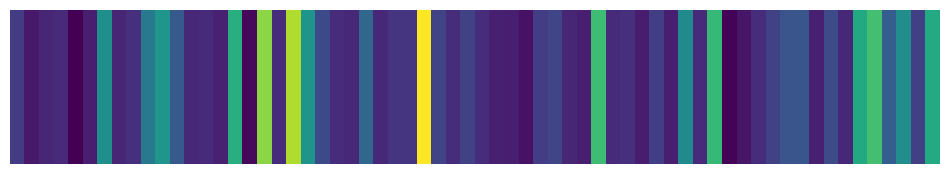

In [31]:
activations = activations[0]
activations = np.array(activations)
plt.figure(figsize=(12, 2))
plt.imshow(activations.reshape(1, -1), cmap='viridis', aspect='auto')
plt.axis('off')
plt.show()

The above plot is just a class activation map of size 64 generated from the last layer in the network before the sigmoid layer.

Cannot really visualize what the ANN model is seeing since it combines the initial input 65536 features using weights and biases and passes it to a final sigmoid function to give predicted probability of class - goal or no goal.

SHAP or Performance Deviation metrics, are not viable for checking how 65536 features individually affect the accuracy of the model since there are too many features.
Only other way to see the explainability of the model is using GRAD CAM in CNN.

#CNN

In [32]:
x_train_cnn = x_train.reshape(-1, 256, 256, 1)

In [33]:
# One hot encoding the y values since we will be using softmax function in the CNN for output
y_train_cnn = to_categorical(y_train, num_classes=2)
y_test_cnn = to_categorical(y_test, num_classes=2)

In [34]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(128,(3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(256,(3,3), activation='relu', padding="same", strides=2,name = 'last_conv'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(2, activation='softmax') # Output layer for binary classification
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 128)      

In [35]:
tf.random.set_seed(42)

In [36]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [37]:
# Train the model
model.fit(x_train_cnn, y_train_cnn, epochs=10)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.6906 - accuracy: 0.5312
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6347 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.8189 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.5868 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.6043 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.5061 - accuracy: 0.8438
Epoch 7/10
1/1 [==============================] - 6s 6s/step - loss: 0.3772 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.2372 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.0747 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 6s 6s/step - loss: 0.0218 - accuracy: 1.0000


In [38]:
x_test_cnn= x_test.reshape(-1, 256, 256, 1)

In [39]:
model.evaluate(x_test_cnn,y_test_cnn)

1/1 [==============================] - 0s 460ms/step - loss: 0.0386 - accuracy: 1.0000


[0.038587816059589386, 1.0]

## Visualizing the class activation maps in CNN using GRAD CAM

1/1 [==============================] - 0s 119ms/step


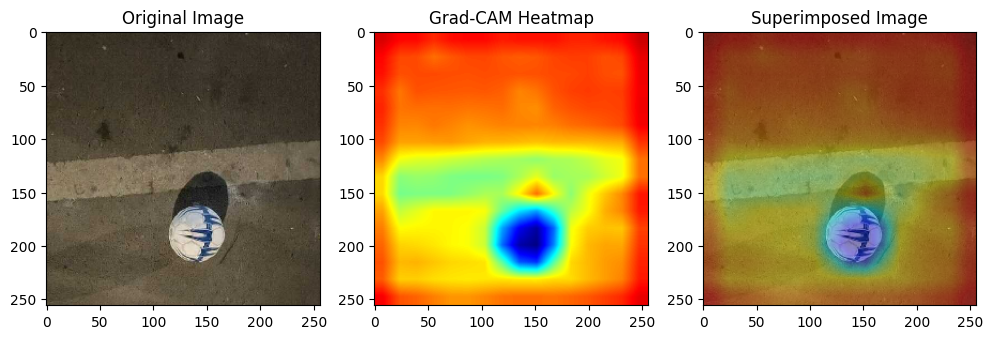

In [40]:
preds = model.predict(np.expand_dims(x_test_cnn[0],axis=0))
class_idx = np.argmax(preds[0])

# get output of last concolutional layer
last_conv_layer = model.get_layer("last_conv")

# create model to get feature maps and predictions
final_layer = model.layers[-1]
cam_model = models.Model(inputs=model.input, outputs=(last_conv_layer.output, final_layer.output))

#input to the model a test image with dimension (1,256,256,1) - 1 image, 256*256 size, 1 meaning grayscale
x_input_test = np.expand_dims(x_test_cnn[0],axis=0)

# get gradient of predicted class with respect to feature map
with tf.GradientTape() as tape:
    conv_output, predictions = cam_model(x_input_test)
    loss = predictions[:, class_idx]

output = conv_output[0]
grads = tape.gradient(loss, conv_output)[0]

# global average pooling of gradients = mean of all gradients
weights = tf.reduce_mean(grads, axis=(0, 1))

# mulitply gradients with last layer's output
cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
cam = np.maximum(cam, 0)
cam = cam / tf.reduce_max(cam)

cam = cam.numpy()

# getting heatmap of features
heatmap = cv2.resize(cam, (256, 256))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img = image.load_img('/content/drive/MyDrive/Datasets/Goal Line Detection/ball/test/goal_test/17goal.jpeg', target_size=(256, 256))

img = np.array(img)

# superimpose on original image
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(132)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.subplot(133)
plt.imshow(superimposed_img)
plt.title("Superimposed Image")
plt.show()

In this project we see how machine learning and deep learning algorithms are able to extract features from images of a football to predict whether it is in goal or not.

The dataset is of total 40 images clicked manually.

Even with this small dataset we are able to see how a CNN is able to see the required features as compared to an LDA model or an ANN model.

The LDA model is able to get a general idea of the placement of the football. But it is not able to clearly separate when the ball is too close to the line.

The ANN model has 128MB worth of parameters as compared to 17MB of the CNN, yet it is not suited to work on image data. The flattened image array which are the input features for the ANN model leads to high dimensionality. The model fails to find the important features required to distinguish between a case of goal or no goal.